In [17]:
import json
import pandas as pd
import re
import numpy as np
import datetime
import collections

import os
from Bio.KEGG import REST
import Bio.TogoWS as TogoWS
from tqdm import tqdm

# Pulling KEGG data 

In [2]:
def create_id_name_dict(db):
    ## Grab list of ids in db
    id_name_dict = dict()
    raw_list = REST.kegg_list(db)
    id_name_list = [s.split('\t') for s in raw_list.read().splitlines()]
    for i in id_name_list:
        id_name_dict[i[0]] = i[1]
    return id_name_dict

In [3]:
def retrieve_entry_info(id_name_dict,db):
    ## Grab each entry in list of ids
    id_entry_dict = {}
    for entry in tqdm(id_name_dict.keys()):

        entry_id = entry.split(":")[1]
        
        try:
            id_entry_dict[entry_id]=json.load(TogoWS.entry(db, entry_id, format="json"))[0]
        except:
            pass

    return id_entry_dict

In [4]:
def write_db_entries(db, datadir):
    ids = create_id_name_dict(db)
    entry_dict = retrieve_entry_info(ids, db)

    ## Write entries to DATADIR
    curr_time = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    json_path = os.path.join(datadir, db, curr_time+".json")

    if not os.path.exists(datadir):
        os.makedirs(datadir)

    with open(json_path, 'w') as f:
        json.dump(entry_dict, f, indent=4)

    return entry_dict

def load_db_entries(jsonfp):
    with open(jsonfp) as f:
        return json.load(f)

In [5]:
DB = "enzyme"
DATADIR = os.path.join("..","data")

# write_db_entries(DB, DATADIR)

100%|██████████| 7890/7890 [50:20<00:00,  2.61it/s]


# Reading existing KEGG Data

In [6]:
EC_ENTRIES_FP = "../data/enzyme/2021-11-16_12-34-21.json"
ec_entries = load_db_entries(EC_ENTRIES_FP)

# Get historical information from EC references

The first enzyme was discovered in 1833 so every matched year should be then or later. 

In [8]:
def match_years(strToSearch, parentheses=False):
    if parentheses == True:
        regex = "\((18[3-9]\d)\)|\((19\d{2})\)|\((20[0-2]\d)\)"
    else:
        regex = "(18[3-9]\d)|(19\d{2})|(20[0-2]\d)"
    return ["".join(i) for i in re.findall(regex,strToSearch)]

In [9]:
# define some class
class EC:
    def __init__(self, ec, years, transferred, deleted):
        self.ec = ec 
        self.years = years
        self.transferred = transferred
        self.deleted = deleted

In [10]:
def retrieve_historical_data_from_ec_entries(ec_entries):
    
    ECs = dict()
    
    for ec, field in ec_entries.items():
        years = []
        transferred = False
        deleted = False
        for ref in field["references"]:
            years_from_year = match_years(ref["year"], parentheses=False)
            if len(years_from_year)>0:
                years+=years_from_year
            else:
                years+=match_years(ref["journal"], parentheses=True)
        
        if "Transferred" in field["name"]: transferred = True
        if "Deleted" in field["name"]: deleted = True

        ECs[ec] = EC(ec, years, transferred, deleted)

    return ECs

In [11]:
ECs = retrieve_historical_data_from_ec_entries(ec_entries)

# Organize into dataframe; add calculated columns

In [14]:
df = pd.DataFrame([vars(ec) for ec in ECs.values()])

In [18]:
def min_year(year_strings):
    if len(year_strings)>0:
        year = int(min([int(i) for i in year_strings]))
        month = 1
        day = 1
        return datetime.date(year,month,day)
    else:
        return pd.NaT

df["min_year"] = df.apply(lambda row: min_year(row["years"]), axis=1)

In [21]:
# df_pivot = pd.pivot_table(df[~df["transferred"] & ~df["deleted"]], index=["min_year"], values=["ec"], aggfunc=lambda x: list(x))

In [26]:
# df_pivot.unstack()

In [ ]:
# df[~df["transferred"] & ~df["deleted"]].groupby("min_year")["ec"].apply(print)

4591     3.1.1.5
4606    3.1.1.20
Name: 1933-01-01, dtype: object
1165    1.6.99.1
Name: 1935-01-01, dtype: object
1332    1.11.1.6
Name: 1936-01-01, dtype: object
0        1.1.1.1
511     1.1.99.2
5144    3.2.1.28
Name: 1937-01-01, dtype: object
4741    3.1.3.5
7802    7.1.1.9
Name: 1938-01-01, dtype: object
563     1.2.1.12
659      1.2.2.1
1224     1.8.1.4
1306    1.10.3.2
5130    3.2.1.14
6113     3.5.4.2
6641     4.2.1.1
Name: 1939-01-01, dtype: object
663       1.2.3.1
1117      1.6.2.4
1331     1.11.1.5
3235      2.4.1.1
5573    3.4.21.25
6070      3.5.2.5
6089      3.5.3.4
Name: 1940-01-01, dtype: object
1272      1.8.5.1
2857      2.1.4.1
5263    3.2.1.147
5441    3.4.11.22
Name: 1941-01-01, dtype: object
4596    3.1.1.10
Name: 1942-01-01, dtype: object
1333    1.11.1.7
1357    1.11.2.2
4747    3.1.3.11
5123     3.2.1.7
5141    3.2.1.25
6388     4.1.1.4
Name: 1943-01-01, dtype: object
4022    2.7.1.40
4594     3.1.1.8
6114     3.5.4.3
6177     3.6.1.1
6402    4.1.1.18
7308    

min_year
1933-01-01    None
1935-01-01    None
1936-01-01    None
1937-01-01    None
1938-01-01    None
              ... 
2017-01-01    None
2018-01-01    None
2019-01-01    None
2020-01-01    None
2021-01-01    None
Name: ec, Length: 88, dtype: object

In [31]:
grouped_df = (df[~df["transferred"] & ~df["deleted"]].groupby("min_year")["ec"]
                                                     .apply(lambda x: len(x))
                                                     .reset_index(name="EC Count"))

In [32]:
grouped_df

,min_year,EC Count
0,1933-01-01,2
1,1935-01-01,1
2,1936-01-01,1
3,1937-01-01,3
4,1938-01-01,2
...,...,...
83,2017-01-01,47
84,2018-01-01,42
85,2019-01-01,23
86,2020-01-01,6


In [33]:
grouped_df["EC Count (cumulative)"] = grouped_df["EC Count"].cumsum()

In [34]:
grouped_df

,min_year,EC Count,EC Count (cumulative)
0,1933-01-01,2,2
1,1935-01-01,1,3
2,1936-01-01,1,4
3,1937-01-01,3,7
4,1938-01-01,2,9
...,...,...,...
83,2017-01-01,47,6499
84,2018-01-01,42,6541
85,2019-01-01,23,6564
86,2020-01-01,6,6570


# Plot

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

## Example

In [39]:
sns.set_theme(style="darkgrid")
sns.set_context("notebook", font_scale=1.5)

In [40]:
# Load an example dataset with long-form data
fmri = sns.load_dataset("fmri")

<AxesSubplot:xlabel='timepoint', ylabel='signal'>

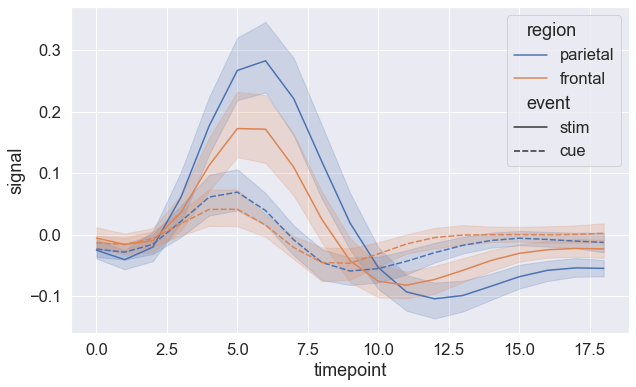

In [41]:
plt.figure(figsize=(10, 6))

# Plot the responses for different events and regions
sns.lineplot(x="timepoint", y="signal",
             hue="region", style="event",
             data=fmri)

## EC data

<AxesSubplot:xlabel='min_year', ylabel='EC Count'>

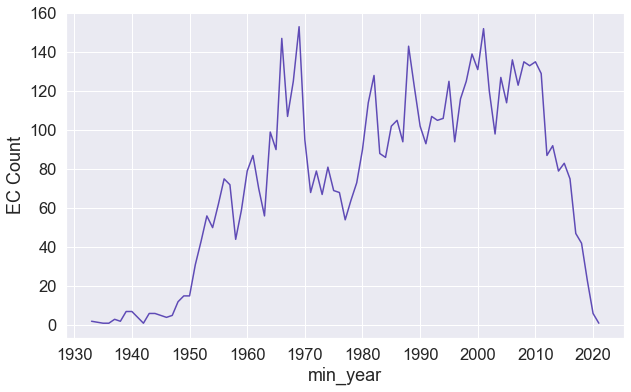

In [42]:
plt.figure(figsize=(10, 6))
sns.lineplot(x="min_year", y="EC Count", data=grouped_df, color="#5F4BB6")

<AxesSubplot:xlabel='min_year', ylabel='EC Count (cumulative)'>

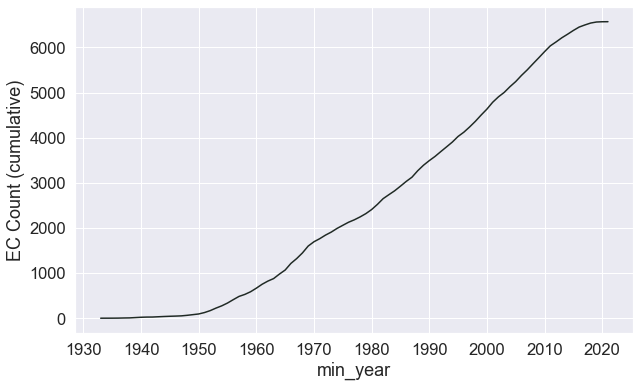

In [43]:
plt.figure(figsize=(10, 6))
sns.lineplot(x="min_year", y="EC Count (cumulative)", data=grouped_df, color="#202A25")

<AxesSubplot:xlabel='min_year', ylabel='EC Count (cumulative)'>

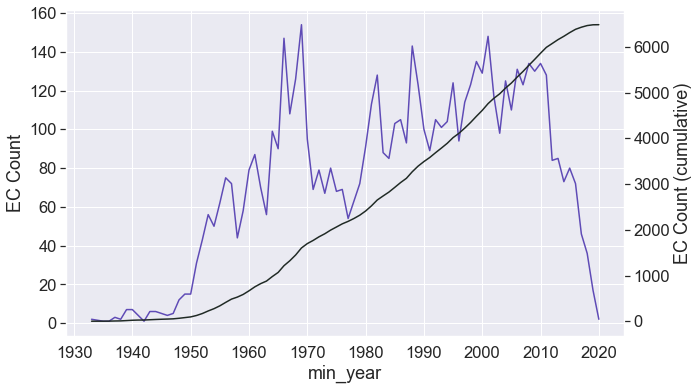

In [194]:
plt.figure(figsize=(10, 6))
sns.lineplot(x="min_year", y="EC Count", data=grouped_df, color="#5F4BB6")
ax2 = plt.twinx()
ax2.grid(False)
sns.lineplot(x="min_year", y="EC Count (cumulative)", data=grouped_df, color="#202A25", ax=ax2)